# PMF: matching requested expectation and variance using SGD

The notebook demonstrates how priors matching requested values of prior predictive expectation and/or variance can be found for Poisson Matrix Factorization model using SGD.

## Setup 


In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [2]:
import tensorflow as tf
tf.enable_eager_execution()
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
tfe = tf.contrib.eager


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [3]:
tf.executing_eagerly()

True

In [4]:
import time
import numpy as np
import pandas as pd

In [5]:
from aux import *

# Configuration

In [6]:
args = parse_script_args()

parsing: <-f>


In [7]:
np.random.seed(int(time.time()))
EID = np.random.randint(10000)

In [8]:
SEED = args.get("SEED", 129)
np.random.seed(SEED)

In [9]:
N, M = 1, 1
K = args.get("K", 25) # factorization dimensions

In [10]:
NITER = args.get("NITER", 20000) + 1 # how many iterations
LR = args.get("LR", 0.1) # learning rate
LAMBDA = args.get("LAMBDA", 0.0) # regularization

In [11]:
# requested values
DESIRED_EXPECTATION = args.get("E", 25)
DESIRED_VARIANCE = args.get("V", 550)

# discrepancy measure: care about E=only expectation, V=only variance, EV=both
D = args.get("D", "V") 
if D=="E": DESIRED_VARIANCE = -1
if D=="V": DESIRED_EXPECTATION = -1
    
# (mean (tf.reduce_mean) should be taken if more than one cell used)
discrepancy_expectation = lambda expectation, variance: (expectation-DESIRED_EXPECTATION)**2 
discrepancy_variance    = lambda expectation, variance: (variance-DESIRED_VARIANCE)**2 
discrepancy_exp_var     = lambda expectation, variance: discrepancy_variance(expectation, variance) + \
                                                        discrepancy_expectation(expectation, variance)

NAME2DISCREPANCY = {"E":  discrepancy_expectation, "EV": discrepancy_exp_var, "V": discrepancy_variance}
discrepancy = NAME2DISCREPANCY[D]

In [12]:
# sampling strategy
SAMPLING = args.get("SAMPLING", 0)
if SAMPLING==0 and LAMBDA<=0.0:
    if D=="E": SAMPLING = 2 # if V is not used
    if D=="V": SAMPLING = 3 # if E is not used

NSAMPLES_LATENT = args.get("S", 1000) # how many samples of latent variables
NSAMPLES_OUTPUT = args.get("SY", 10)  # how many samples of outputs for each latent

In [13]:
# optimization initial values (always in terms of abcd parametrization)

a0, b0, c0, d0 = args.get("a", None), args.get("b", None), args.get("c", None), args.get("d", None) # random init
#a0, b0, c0, d0 = args.get("a", 0.1), args.get("b", 0.1), args.get("c", 0.1), args.get("d", 0.1)
#a0=0.0001; b0=0.001; c0=0.010; d0=0.100 # Crashing initialization!

# if not set choose randomly mu-s and sigma-s from 10**e, e in [1e-3, 1e3]
if a0 is None or a0<=0:
    mut = 10**(np.random.random()*6.0-3.0) 
    sigmat = 10**(np.random.random()*6.0-3.0) 
    mub = 10**(np.random.random()*6.0-3.0) 
    sigmab = 10**(np.random.random()*6.0-3.0) 
    a0,b0 = (mut*mut)/(sigmat*sigmat), mut/(sigmat*sigmat)
    c0,d0 = (mub*mub)/(sigmab*sigmab), mub/(sigmab*sigmab)
    print("Random initialization: mut=%.3f st=%.3f mub=%.3f sb=%.3f" % (mut, sigmat, mub, sigmab))

# which parameter space
PARAMETRIZATION = args.get("PARAMETRIZATION", "musigma") # musigma/abcd
# how to transform from unbounded space to a bounded one and vice versa
VARIABLES_TRANSFORMATION = args.get("TRANSFORMATION", "softplus") # softplus/exp
# which of the parameters to train
TRAINABLE = args.get("TRAIN", "0123") 

In [14]:
DESCRIPTION = dict2str(globals()).replace("NSAMPLES", "S").replace("DESIRED_", "").replace("EXPECTATION", "E").replace("VARIANCE", "V").replace("TRAINABLE", "TT")
DESCRIPTION = "a=%.3f b=%.3f c=%.3f d=%.3f %s" % (a0,b0,c0,d0,DESCRIPTION)
print("DESCRIPTION: %s" % DESCRIPTION)

ID = str(args.get("ID", DESCRIPTION))

DESCRIPTION: a=0.100 b=0.100 c=0.100 d=0.100 D=V E=-1 V=550 EID=4677 K=25 LAMBDA=0.0 LR=0.1 M=1 N=1 NITER=10001 S_LATENT=1000 S_OUTPUT=10 PARAMETRIZATION=musigma SAMPLING=3 SEED=129 TT=0123 VARIABLES_TRANSFORMATION=softplus


# Parameterization and transformation

We consider two problem parametrizations: either abcd or mu-sigma.
Also, we need to perform a transformation from unconstrained space.

In [15]:
def abcd2musigma(a, b, c, d, env=tf):    
    return a/b, env.sqrt(a)/b, c/d, env.sqrt(c)/d
  

def musigma2abcd(mut, sigmat, mub, sigmab):    
    a,b = (mut*mut)/(sigmat*sigmat), mut/(sigmat*sigmat)
    c,d = (mub*mub)/(sigmab*sigmab), mub/(sigmab*sigmab)
    return a, b, c, d


def abcd2abcd(a, b, c, d, env=tf):    
    return a,b,c,d

In [16]:
from tensorflow.contrib.distributions import softplus_inverse
#softplus_inverse = lambda v: tf.log(tf.exp(v)-1.0)
NAME2TRANSFORMATION = {"softplus": (tf.nn.softplus, softplus_inverse), "exp": (tf.exp, np.log)}
forward_transformation, backward_transformation = NAME2TRANSFORMATION[VARIABLES_TRANSFORMATION]

print("forward_transformation:=%s backward_transformation:=%s" % 
      (forward_transformation.__name__, backward_transformation.__name__))
#print("  transformation prec:", np.array(backward_transformation(forward_transformation(a0))-a0))

NAME2PARAMETRIZATION = {"abcd": (abcd2abcd, abcd2abcd), "musigma": (musigma2abcd, abcd2musigma)}
forward_parametrization, backward_parametrization = NAME2PARAMETRIZATION[PARAMETRIZATION]

print("forward_parametrization:=%s backward_parametrization:=%s " % 
      (forward_parametrization.__name__, backward_parametrization.__name__))
#print("  parametrization prec:", forward_parametrization(*backward_parametrization(a0,b0,c0,d0))-np.array([a0,b0,c0,d0]))
#assert (np.round(inverse_parametrization(*parametrization(a0,b0,c0,d0))-np.array([a0,b0,c0,d0]),2) ==0).all()

forward_transformation:=softplus backward_transformation:=softplus_inverse
forward_parametrization:=musigma2abcd backward_parametrization:=abcd2musigma 


# Choose expectation & variance estimators

In [17]:
from pmf_model import create_moments_estimator
theoretical_moments = create_moments_estimator(K=25, ESTIMATOR_NO=-1, N=1, M=1)
empirical_moments   = create_moments_estimator(K=25, ESTIMATOR_NO=SAMPLING, N=1, M=1)
print("empirical_moments := %s" % empirical_moments.__name__)

empirical_moments := empirical_moments_V_decoupled


In [18]:
e, v = theoretical_moments(a0, b0, c0, d0)
print("Initialization: a=%.3f\tb=%.3f\tc=%.3f\td=%.3f\t=> E=%.4f \tV=%.4f" % (a0, b0, c0, d0, e, v))

Initialization: a=0.100	b=0.100	c=0.100	d=0.100	=> E=25.0000 	V=3025.0000


# Find hyperparameters matching desired values

In [19]:
tf.random.set_random_seed(SEED)
np.random.seed(SEED)

In [20]:
# init (unbounded) params
float1 = lambda v: tf.Variable(float(v), dtype=tf.float64)
float2 = lambda v: tf.Variable(v, dtype=tf.float64)

a0tf, b0tf, c0tf, d0tf = float2(a0), float2(b0), float2(c0), float2(d0)
i0, i1, i2, i3 = backward_parametrization(a0tf, b0tf, c0tf, d0tf, env=tf)
#i0, i1, i2, i3 = float1(i0), float1(i1), float1(i2), float1(i3)

p0u = tf.Variable(backward_transformation(i0), name="0", dtype=tf.float64) 
p1u = tf.Variable(backward_transformation(i1), name="1", dtype=tf.float64) 
p2u = tf.Variable(backward_transformation(i2), name="2", dtype=tf.float64) 
p3u = tf.Variable(backward_transformation(i3), name="3", dtype=tf.float64) 

print("Initialization: i0=%.3f, i1=%.3f, i2=%.3f, i3=%.3f" % 
      (i0.numpy(), i1.numpy(), i2.numpy(), i3.numpy()))
print("Initialization: p0u=%.3f, p1u=%.3f, p2u=%.3f, p3u=%.3f" % 
      (p0u.numpy(), p1u.numpy(), p2u.numpy(), p3u.numpy()))

Instructions for updating:
Colocations handled automatically by placer.
Initialization: i0=1.000, i1=3.162, i2=1.000, i3=3.162
Initialization: p0u=0.541, p1u=3.119, p2u=0.541, p3u=3.119


In [21]:
trainable_variables = [var for var in [p0u, p1u, p2u, p3u] if var.name.split(":")[0] in TRAINABLE]
optimizer = tf.train.AdamOptimizer(learning_rate=LR)
start = time.time()
computation_time = 0.0
results = []

In [22]:
best_loss = float("inf")
best_a, best_b, best_c, best_d = -1.0, -1.0, -1.0, -1.0
best_E, best_V = -1.0, -1.0

In [23]:
for iteration in range(NITER):
  
    ##########################################################################################################
    # Optimization
    iteration_start_time = time.time()
        
    with tf.GradientTape() as tape:        
        p1,p2 = forward_transformation(p0u), forward_transformation(p1u) 
        p3,p4 = forward_transformation(p2u), forward_transformation(p3u) 
        
        a,b,c,d =  forward_parametrization(p1,p2,p3,p4)           
        expectation, variance = empirical_moments(a, b, c, d, NSAMPLES_LATENT, NSAMPLES_OUTPUT)        
        loss = discrepancy(expectation, variance) -(LAMBDA*variance if LAMBDA>0 else 0.0) # just to be sure
    
    grads = tape.gradient(loss, trainable_variables)              
    optimizer.apply_gradients(zip(grads, trainable_variables), global_step=tf.train.get_or_create_global_step())
    expectation_exact, variance_exact = theoretical_moments(a, b, c, d)
    #print(iteration,">>",a,b,c,d,expectation_exact, variance_exact)
    computation_time += (time.time()-iteration_start_time)
    
    if loss<best_loss: #TODO Can do better by evaluating here the loss with more samples
        best_loss = loss.numpy()
        best_a, best_b, best_c, best_d = a.numpy(), b.numpy(), c.numpy(), d.numpy()
        best_E, best_V = theoretical_moments(best_a, best_b, best_c, best_d)
        
    ##########################################################################################################
    # Reporting:
    failed = not is_valid(np.array(expectation))
    elapsed = time.time() - start
    if (failed) or (iteration<100) or (iteration%50==0): 
        r = (ID, D, SEED,
             a0, b0, c0, d0, NITER, LR,
             K, NSAMPLES_LATENT, NSAMPLES_OUTPUT, 
             DESIRED_EXPECTATION, DESIRED_VARIANCE, LAMBDA,
             ((NITER-1) if failed else iteration), computation_time, 
             a.numpy(), b.numpy(), c.numpy(), d.numpy(), 
             loss.numpy(), expectation_exact.numpy(), variance_exact.numpy(), expectation.numpy(), variance.numpy(),
             best_loss, best_a, best_b, best_c, best_d, best_E, best_V,
             failed)
        results.append(r)

    if (failed) or (iteration<10) or (iteration<1000 and iteration%100==0)  or (iteration%1000==0): 
        print("[%.2f][%.2f] best:\tloss:%.1f\thyperparams: a=%.5f b=%.5f c=%.5f d=%.5f => E=%.3f V=%.3f" % 
              (computation_time, elapsed, best_loss, best_a, best_b, best_c, best_d, best_E, best_V))        
        print("[%.2f][%.2f] %i/%i,\tloss:%.1f\thyperparams: a=%.5f b=%.5f c=%.5f d=%.5f" % 
              (computation_time, elapsed, iteration, NITER, loss.numpy(), 
               a.numpy(), b.numpy(), c.numpy(), d.numpy()))                
        print(" empirical: E: %.2f V: %.2f" % (expectation, variance) )    
        print(" theoretic: E: %.2f V: %.2f" % (expectation_exact, variance_exact) )
        print(" desired: E: %.2f V: %.2f" % (DESIRED_EXPECTATION, DESIRED_VARIANCE) )                
        sys.stdout.flush()
        
    if failed:
        print("Error: ran into invalid values!")
        break

[0.07][0.12] best:	loss:2994833.8	hyperparams: a=0.10000 b=0.10000 c=0.10000 d=0.10000 => E=25.000 V=3025.000
[0.07][0.12] 0/10001,	loss:2994833.8	hyperparams: a=0.10000 b=0.10000 c=0.10000 d=0.10000
 empirical: E: 24.32 V: 2280.56
 theoretic: E: 25.00 V: 3025.00
 desired: E: -1.00 V: 550.00
[0.11][0.16] best:	loss:2994833.8	hyperparams: a=0.10000 b=0.10000 c=0.10000 d=0.10000 => E=25.000 V=3025.000
[0.11][0.16] 1/10001,	loss:6011538.4	hyperparams: a=0.09355 b=0.09973 c=0.09355 d=0.09973
 empirical: E: 21.08 V: 3001.84
 theoretic: E: 21.99 V: 2646.94
 desired: E: -1.00 V: 550.00
[0.16][0.21] best:	loss:2994833.8	hyperparams: a=0.10000 b=0.10000 c=0.10000 d=0.10000 => E=25.000 V=3025.000
[0.16][0.21] 2/10001,	loss:6820162.2	hyperparams: a=0.08707 b=0.09915 c=0.08710 d=0.09918
 empirical: E: 19.67 V: 3161.54
 theoretic: E: 19.28 V: 2321.86
 desired: E: -1.00 V: 550.00
[0.20][0.25] best:	loss:2994833.8	hyperparams: a=0.10000 b=0.10000 c=0.10000 d=0.10000 => E=25.000 V=3025.000
[0.20][0.25

In [24]:
path = ID+".csv"
print("Saving results to: %s" % path)
df = pd.DataFrame(results)
CN = ["ID", "D", "SEED", "a0", "b0", "c0", "d0", "NITER", "LR", "K", "S", "SY", "E", "V", "LAMBDA",
      "iteration", "elapsed", "ct", "rt", "cb", "rb", "loss", "Et", "Vt", "Ee", "Ve", 
      "best_loss", "best_a", "best_b", "best_c", "best_d", "best_E", "best_V", "failed"]
df.rename(columns=dict(enumerate(CN)), inplace=True)
df.to_csv(path, header=True, index=False);

Saving results to: a=0.100 b=0.100 c=0.100 d=0.100 D=V E=-1 V=550 EID=4677 K=25 LAMBDA=0.0 LR=0.1 M=1 N=1 NITER=10001 S_LATENT=1000 S_OUTPUT=10 PARAMETRIZATION=musigma SAMPLING=3 SEED=129 TT=0123 VARIABLES_TRANSFORMATION=softplus.csv


# Visualization

In [25]:
from aux_plt import *
import warnings
warnings.filterwarnings("ignore")

## Convergence analysis

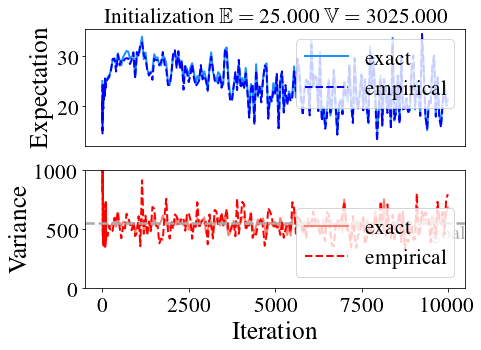

In [28]:
  start_plotting(cmbright=False)
  ax2 = plt.subplot(212)
  ax1 = plt.subplot(211)

  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  iteration = means.iteration
    
  e, var = theoretical_moments(a0,b0,c0,d0)
  #label="E=%.0f V=%.0f (a=%s b=%s c=%s d=%s)" % (e, var, f(a0),f(b0),f(c0),f(d0))
  plt.title(r"Initialization $\mathbb{E}=%.3f$ $\mathbb{V}=%.3f$" % (e, var))
    
  plt.sca(ax1)
  errorfill((iteration), (means["Et"]), (stds["Et"]), color="dodgerblue", 
            alpha_fill=0.1, label="exact", smooth=0)
  errorfill((iteration), (means["Ee"]), (stds["Ee"]), color="blue", 
            alpha_fill=0.1, label="empirical", smooth=0, ls="--")
  plt.sca(ax2)
  errorfill((iteration), (means["Vt"]), (stds["Vt"]), color="salmon", 
            alpha_fill=0.1, label="exact", smooth=0)
  errorfill((iteration), (means["Ve"]), (stds["Ve"]), color="red", 
            alpha_fill=0.1, label="empirical", smooth=0, ls="--")

  plt.sca(ax2)
  plt.xlabel("Iteration")
  plt.ylabel(r"Variance")
  goal = means["V"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
  plt.legend()
  plt.ylim(0,1000)
  
  plt.sca(ax1)
  plt.legend()
  plt.xticks([],[])
  plt.ylabel(r"Expectation")
  goal = means["E"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
    
  plt.show()

## The best value(s) found up to certain iteration

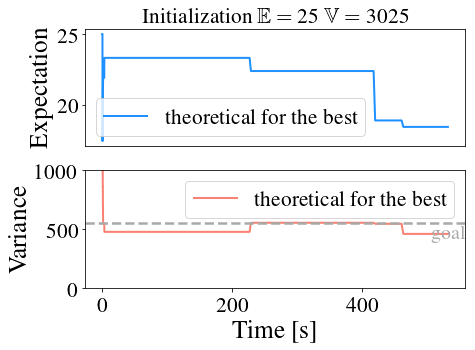

In [27]:
  start_plotting(cmbright=False)
  ax2 = plt.subplot(212)
  ax1 = plt.subplot(211)

  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  #xs = means.iteration; xlabel = "Iteration" # Iteration on horizontal axis
  xs = means.elapsed; xlabel = "Time [s]" # Time on horizontal axis
    
  e, var = theoretical_moments(a0,b0,c0,d0)
  #label="E=%.0f V=%.0f (a=%s b=%s c=%s d=%s)" % (e, var, f(a0),f(b0),f(c0),f(d0))
  plt.title(r"Initialization $\mathbb{E}=%.0f$ $\mathbb{V}=%.0f$" % (e, var))
    
  plt.sca(ax1)
  errorfill((xs), (means["best_E"]), (stds["best_E"]), color="dodgerblue", 
            alpha_fill=0.1, label="theoretical for the best", smooth=0)
  plt.sca(ax2)
  errorfill((xs), (means["best_V"]), (stds["best_V"]), color="salmon", 
            alpha_fill=0.1, label="theoretical for the best", smooth=0)

  plt.sca(ax2)      
  plt.xlabel(xlabel)
  plt.ylabel(r"Variance")
  goal = means["V"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
  plt.legend()
  plt.ylim(0,1000)
    
  
  plt.sca(ax1)
  plt.legend()
  plt.xticks([],[])
  plt.ylabel(r"Expectation")
  goal = means["E"][0]
  if goal>-1:
    x1,x2 = plt.xlim()
    plt.axhline(goal, lw=2.5, color="darkgray", ls="--")
    plt.text(x2,goal, r"goal $~$", va="top", ha="right", fontsize=20, color="darkgray")
    
  plt.show()

## Hyperameters' values during optimization

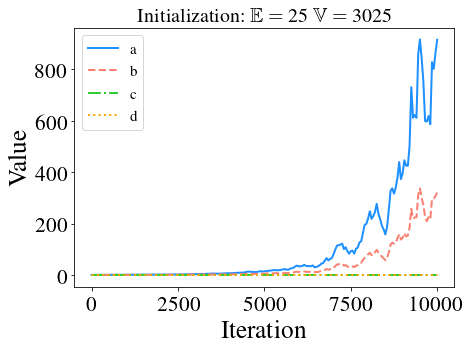

In [29]:
  start_plotting(cmbright=False)
  
  means = df.groupby(["iteration"]).mean().reset_index()
  stds = df.groupby(["iteration"]).std().reset_index()
  assert (means.iteration == stds.iteration).all()
  iteration = means.iteration  
  
  e, var = theoretical_moments(a0,b0,c0,d0)
  plt.title(r"Initialization: $\mathbb{E}=%.0f$ $\mathbb{V}=%.0f$" % (e, var), fontsize=20)
  
  errorfill((iteration), (means["cb"]), (stds["cb"]), color=COLORS[0], alpha_fill=0.2, smooth=0, ls="-", label="a")
  errorfill((iteration), (means["rb"]), (stds["rb"]), color=COLORS[1], alpha_fill=0.2, smooth=0, ls="--", label="b")
  errorfill((iteration), (means["ct"]), (stds["ct"]), color=COLORS[2], alpha_fill=0.2, smooth=0, ls="-.", label="c")
  errorfill((iteration), (means["ct"]), (stds["ct"]), color="orange", alpha_fill=0.2, smooth=0, ls="dotted", label="d")

  plt.legend(fontsize=15)  
  plt.xlabel("Iteration")
  plt.ylabel("Value")
  plt.show()  